### Installing Detectron2

At the time of this writing, Detectron2 is still in an alpha stage. While there is an official release, we'll clone and compile from the master branch. This should equal version 0.1.

Let's start by installing some requirements:

## STEP1: Install some requirements

In [30]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6 requires pycocotools>=2.0.2, but you have pycocotools 2.0 which is incompatible.


## Step2: Download, compile, and install the Detectron2 package:

In [31]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13686, done.
remote: Counting objects: 100% (1187/1187), done.
remote: Compressing objects: 100% (566/566), done.
remote: Total 13686 (delta 769), reused 886 (delta 612), pack-reused 12499
Receiving objects: 100% (13686/13686), 5.81 MiB | 3.71 MiB/s, done.
Resolving deltas: 100% (9725/9725), done.
Checking out files: 100% (758/758), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
watermark 2.2.0 requires importlib-metadata<3.0; python_version < "3.8", but you have importlib-metadata 4.8.2 which is incompatible.


## Step3: restart the notebook runtime to continue!

In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.


## Step4: Install watermark and mmcv

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
pycocotools: 2.0.3
torch      : 1.10.0+cu111
torchvision: 0.11.1+cu111
detectron2 : 0.6



In [3]:
!pip install mmcv

## Step5: Import packages we need, and set seed

In [4]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import sys
import torch
import mmcv
import itertools
from detectron2.structures import BoxMode

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
from google.colab import drive

drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
os.chdir('./gdrive/MyDrive/DL_visualization/VRDL_HW3')

In [7]:
classes = ["nucleus"]

## Step6: Set up the config file and change the hyperparameters and path.

In [29]:
with open('./train.json', newline='') as jsonfile:
  train_df = json.load(jsonfile)
with open('./val.json', newline='') as jsonfile_test:
  val_df = json.load(jsonfile_test)
with open('./data.json', newline='') as jsonfile_test:
  df = json.load(jsonfile_test)

In [30]:
for d in ["train", "val"]:
  DatasetCatalog.register("nucleus_" + d, lambda d=d: train_df if d == "train" else val_df)
  MetadataCatalog.get("nucleus_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("nucleus_train")

In [8]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
cfg = get_cfg()
cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [10]:
cfg.DATALOADER.NUM_WORKERS = 4

In [11]:
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [12]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 100

In [13]:
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500   
cfg.SOLVER.STEPS = []        # do not decay learning rate

In [14]:
cfg.OUTPUT_DIR = './output_test'
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Testing

## Step7: Create another folder named annotated_results to save the test images with predictions.

## Step8: Create a test dataframe in coco format sorted by specific order

In [28]:
os.makedirs("annotated_results", exist_ok=True)
test_image_paths = ["TCGA-A7-A13E-01Z-00-DX1.jpg", "TCGA-50-5931-01Z-00-DX1.jpg", "TCGA-G2-A2EK-01A-02-TSB.jpg", "TCGA-AY-A8YK-01A-01-TS1.jpg", "TCGA-G9-6336-01Z-00-DX1.jpg", "TCGA-G9-6348-01Z-00-DX1.jpg"]

In [17]:
def get_test(data):
  images = []
  dataset_dicts = []
  for idx in range(len(data)):
      # load images ad masks
      path = data[idx]
      record = {}
      record["file_name"] ='./data/test_jpg/' +  path
      record["height"] = 1000
      record["width"] = 1000
      record["image_id"] = idx
      dataset_dicts.append(record)
  return dataset_dicts

In [18]:
test_df = get_test(test_image_paths)
test_df

[{'file_name': './data/test_jpg/TCGA-A7-A13E-01Z-00-DX1.jpg',
  'height': 1000,
  'image_id': 0,
  'width': 1000},
 {'file_name': './data/test_jpg/TCGA-50-5931-01Z-00-DX1.jpg',
  'height': 1000,
  'image_id': 1,
  'width': 1000},
 {'file_name': './data/test_jpg/TCGA-G2-A2EK-01A-02-TSB.jpg',
  'height': 1000,
  'image_id': 2,
  'width': 1000},
 {'file_name': './data/test_jpg/TCGA-AY-A8YK-01A-01-TS1.jpg',
  'height': 1000,
  'image_id': 3,
  'width': 1000},
 {'file_name': './data/test_jpg/TCGA-G9-6336-01Z-00-DX1.jpg',
  'height': 1000,
  'image_id': 4,
  'width': 1000},
 {'file_name': './data/test_jpg/TCGA-G9-6348-01Z-00-DX1.jpg',
  'height': 1000,
  'image_id': 5,
  'width': 1000}]

In [22]:
for d in ["test"]:
  DatasetCatalog.register("nucleus_test", lambda d=d: test_df)
  MetadataCatalog.get("nucleus_test").set(thing_classes=classes)

## Step9: Specificy the datasets. Use DefaultPredictor to predict the results.

## Step10: Get the results in cocoformat using cocoevalutor.

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("nucleus_test",)
cfg.TEST.DETECTIONS_PER_IMAGE = 100
predictor = DefaultPredictor(cfg)

In [24]:
evaluator = COCOEvaluator("nucleus_test", cfg, False, output_dir="./output_test/")
val_loader = build_detection_test_loader(cfg, "nucleus_test")
# trainer = CocoTrainer(cfg) 
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [12/14 08:34:35 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/14 08:34:35 d2.evaluation.coco_evaluation]: Trying to convert 'nucleus_test' to COCO format ...
WARNING [12/14 08:34:35 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output_test/nucleus_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[12/14 08:34:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 08:34:35 d2.data.common]: Serializing 6 elements to byte tensors and concatenating them all ...
[12/14 08:34:35 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/14 08:34:35 d2.evaluation.evaluator]: Start inference on 6 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/14 08:34:44 d2.evaluation.evaluator]: Total inference time: 0:00:01.542322 (1.542322 s / iter per device, on 1 devices)
[12/14 08:34:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (1.153959 s / iter per device, on 1 devices)
[12/14 08:34:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/14 08:34:44 d2.evaluation.coco_evaluation]: Saving results to ./output_test/coco_instances_results.json
[12/14 08:34:44 d2.evaluation.coco_evaluation]: Annotations are not available for evaluation.


OrderedDict()

# DRAW

## Step11: Draw the results to check the correctness.

In [25]:
IMAGES_PATH = f'./data/test_jpg'

In [31]:
import sys
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1., 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

In [33]:
annotated_images = [f'annotated_results/{f}' for f in test_image_paths]

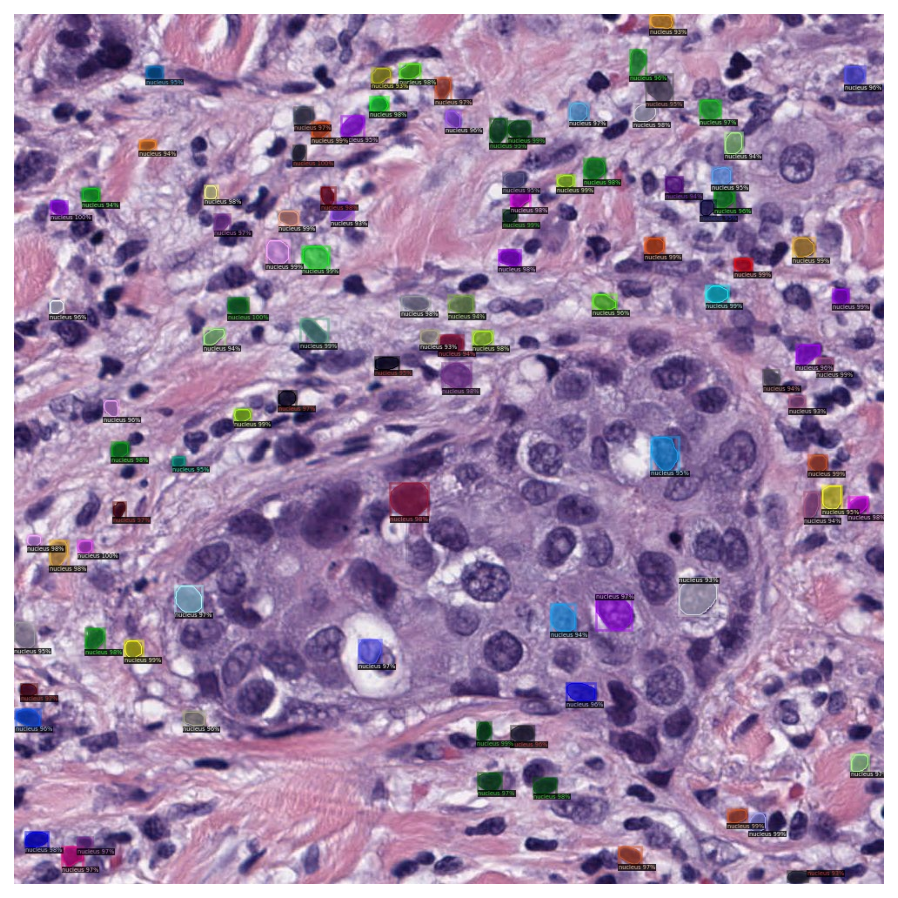

In [34]:
img = cv2.cvtColor(cv2.imread(annotated_images[0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off');

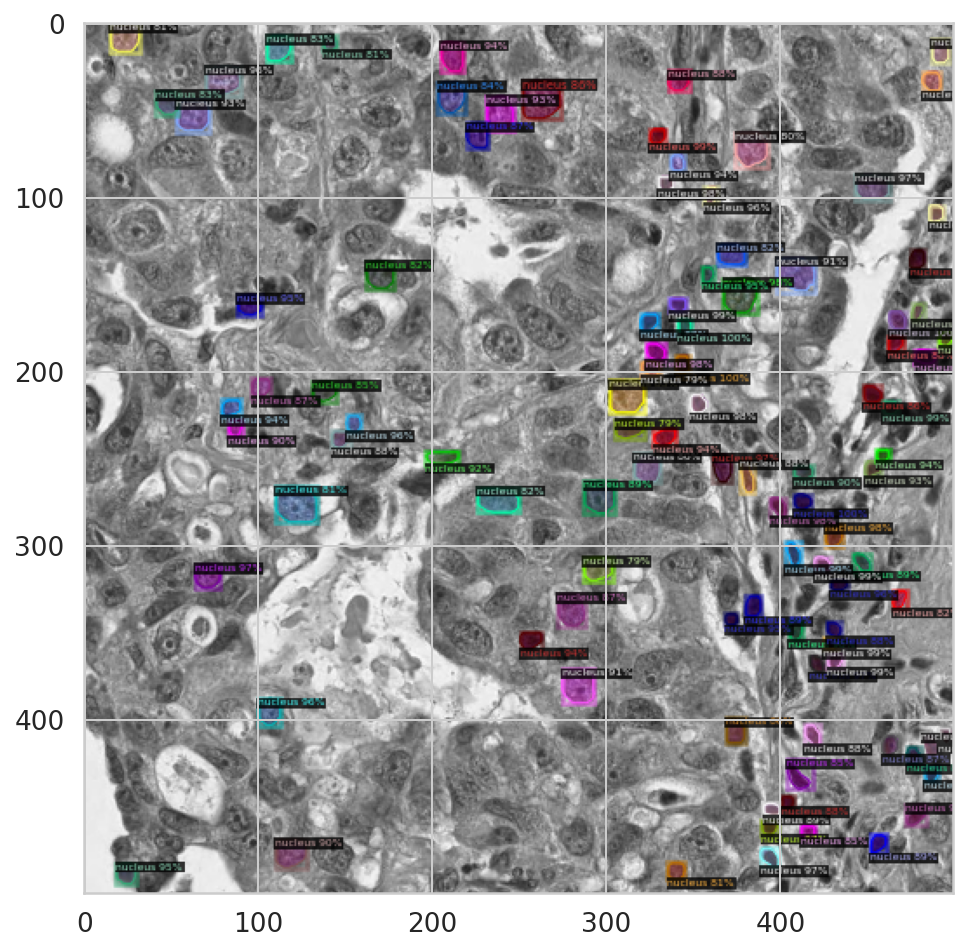

In [35]:
im = cv2.imread(val_df[0]["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=statement_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])